### Bibliotecas


In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from flaml import AutoML
from imblearn.over_sampling import SMOTE

### Carregando Dados

In [76]:
df_sf = pd.read_csv(r'D:\Projetos\UFABC\UFABC_Tambra\Dados\SoftFailure_dataset.csv')
df_hd = pd.read_csv(r'D:\Projetos\UFABC\UFABC_Tambra\Dados\HardFailure_dataset.csv')

### Preparação dos dados

#### Junção DFS

In [77]:
# Criando classiicação

df_sf['Base'] =  'SOFT'
df_hd['Base'] = 'HARD'

In [78]:
df_fail = pd.concat([df_sf, df_hd], ignore_index=True)

#### Conversão para datetime

In [79]:
df_fail['Timestamp_s'] = pd.to_datetime(df_fail.Timestamp,unit='s')#[[0]]
df_fail['Timestamp_data'] = df_fail['Timestamp_s'].astype(str).str.split(expand=True)[0]
df_fail['Timestamp_hora'] = df_fail['Timestamp_s'].astype(str).str.split(expand=True)[1]

#### Replice Failure - NaN = 0


In [80]:
df_fail.Failure = df_fail.Failure.replace(np.nan,0).astype(int)

### Interpolação - Tratamento de NaN nas Features Numéricas

In [81]:
# Para dados de série temporal, a interpolação é uma ótima estratégia.
# Ela preenche os valores ausentes com base nos valores vizinhos.
# Primeiro, vamos ordenar o DataFrame pelo tempo para garantir que a interpolação funcione corretamente.
df_fail = df_fail.sort_values(by='Timestamp').reset_index(drop=True)

In [82]:
#### O pandas pode preencher os valores ausentes estimando o que eles deveriam ser com base nos valores vizinhos (anteriores e posteriores).

features_numericas = ['BER', 'OSNR', 'InputPower', 'OutputPower']
df_fail[features_numericas] = df_fail[features_numericas].interpolate(method='linear')

In [83]:
df_fail.InputPower = df_fail.InputPower.replace(np.nan,0)
df_fail.OutputPower = df_fail.OutputPower.replace(np.nan,0)

### Exploração dos dados

In [84]:
df_fail

,Timestamp,Type,ID,BER,OSNR,InputPower,OutputPower,Failure,Base,Timestamp_s,Timestamp_data,Timestamp_hora
0,1623394634,Devices,SPO1/18/11,2.280000e-08,38.500000,0.00,0.00,0,HARD,2021-06-11 06:57:14,2021-06-11,06:57:14
1,1623394635,Devices,SPO2/18/11,8.730000e-07,23.500000,0.00,0.00,0,HARD,2021-06-11 06:57:15,2021-06-11,06:57:15
2,1623394635,Infrastructure,Ampli4,7.303667e-07,26.016667,-22.90,0.70,0,HARD,2021-06-11 06:57:15,2021-06-11,06:57:15
3,1623394635,Infrastructure,Ampli3,5.877333e-07,28.533333,-16.70,0.80,0,HARD,2021-06-11 06:57:15,2021-06-11,06:57:15
4,1623394635,Infrastructure,Ampli2,4.451000e-07,31.050000,-15.50,0.40,0,HARD,2021-06-11 06:57:15,2021-06-11,06:57:15
...,...,...,...,...,...,...,...,...,...,...,...,...
119425,1624486451,Infrastructure,Ampli4,7.306667e-08,34.300000,-22.90,0.70,0,SOFT,2021-06-23 22:14:11,2021-06-23,22:14:11
119426,1624486451,Infrastructure,Ampli1,1.215333e-07,30.000000,-19.20,0.70,0,SOFT,2021-06-23 22:14:11,2021-06-23,22:14:11
119427,1624486451,Devices,SPO2/18/11,1.700000e-07,25.700000,-17.95,0.75,0,SOFT,2021-06-23 22:14:11,2021-06-23,22:14:11
119428,1624486451,Infrastructure,Ampli3,1.700000e-07,25.700000,-16.70,0.80,0,SOFT,2021-06-23 22:14:11,2021-06-23,22:14:11


In [85]:
df_fail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119430 entries, 0 to 119429
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       119430 non-null  int64         
 1   Type            119430 non-null  object        
 2   ID              119430 non-null  object        
 3   BER             119430 non-null  float64       
 4   OSNR            119430 non-null  float64       
 5   InputPower      119430 non-null  float64       
 6   OutputPower     119430 non-null  float64       
 7   Failure         119430 non-null  int64         
 8   Base            119430 non-null  object        
 9   Timestamp_s     119430 non-null  datetime64[ns]
 10  Timestamp_data  119430 non-null  object        
 11  Timestamp_hora  119430 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 10.9+ MB


In [86]:
df_fail.describe()

,Timestamp,BER,OSNR,InputPower,OutputPower,Failure,Timestamp_s
count,1.194300e+05,1.194300e+05,119430.000000,119430.000000,119430.000000,119430.000000,119430
mean,1.623889e+09,1.846473e-04,30.590290,-19.582524,0.648359,0.063728,2021-06-17 00:14:02.432923136
min,1.623395e+09,0.000000e+00,0.000000,-38.000000,0.000000,0.000000,2021-06-11 06:57:14
25%,1.623411e+09,2.370000e-08,25.400000,-22.900000,0.550000,0.000000,2021-06-11 11:24:37
50%,1.623427e+09,1.747500e-07,31.000000,-19.200000,0.700000,0.000000,2021-06-11 15:58:39
75%,1.624470e+09,6.166938e-07,38.500000,-16.700000,0.700000,0.000000,2021-06-23 17:46:46
max,1.624486e+09,2.651316e-02,38.600000,0.000000,0.900000,1.000000,2021-06-23 22:14:11
std,5.271721e+05,1.212574e-03,6.921175,3.740281,0.132266,0.244268,NaN


In [87]:
df_fail.Type.unique()

array(['Devices', 'Infrastructure'], dtype=object)

In [88]:
df_fail.ID.unique()

array(['SPO1/18/11', 'SPO2/18/11', 'Ampli4', 'Ampli3', 'Ampli2', 'Ampli1'],
      dtype=object)

In [89]:
df_fail.corr(numeric_only=True)

,Timestamp,BER,OSNR,InputPower,OutputPower,Failure
Timestamp,1.000000,-0.129228,0.131924,0.139648,0.015441,0.121965
BER,-0.129228,1.000000,-0.260976,-0.064315,-0.016382,-0.020029
OSNR,0.131924,-0.260976,1.000000,0.059078,-0.004025,-0.132893
InputPower,0.139648,-0.064315,0.059078,1.000000,-0.395968,-0.154167
OutputPower,0.015441,-0.016382,-0.004025,-0.395968,1.000000,-0.041835
Failure,0.121965,-0.020029,-0.132893,-0.154167,-0.041835,1.000000


<Axes: >

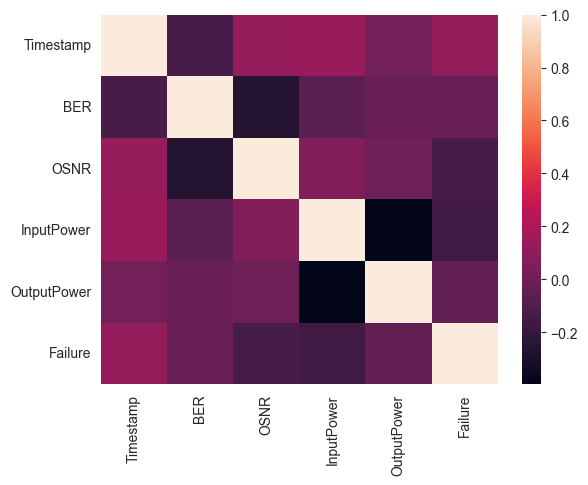

In [90]:
sns.heatmap(df_fail.corr(numeric_only=True))

### Engenharia de Features

#### 1. Features de Janela Deslizante (Rolling Window)

In [91]:
# Vamos criar features que representam a média, desvio padrão, mínimo e máximo dos sensores em diferentes janelas de tempo (5, 15 e 30 períodos).
# Obs: Os cálculos devem ser feitos para cada equipamento (ID) separadamente.

# Garante que os dados estão ordenados por equipamento e tempo
df_feat = df_fail.sort_values(by=['ID', 'Timestamp_s']).copy()

features_to_engineer = ['BER', 'OSNR', 'InputPower', 'OutputPower']
window_sizes = [5, 15, 30]  # Janelas de 5, 15 e 30 períodos

In [92]:
for feature in features_to_engineer:
    for window in window_sizes:
        # Agrupa por ID e aplica a janela deslizante
        rolling_mean = df_feat.groupby('ID')[feature].rolling(window=window, min_periods=1).mean().reset_index(
            drop=True)
        rolling_std = df_feat.groupby('ID')[feature].rolling(window=window, min_periods=1).std().reset_index(drop=True)
        rolling_max = df_feat.groupby('ID')[feature].rolling(window=window, min_periods=1).max().reset_index(drop=True)

        df_feat[f'{feature}_mean_{window}'] = rolling_mean
        df_feat[f'{feature}_std_{window}'] = rolling_std
        df_feat[f'{feature}_max_{window}'] = rolling_max

print("Features de janela deslizante criadas.")

Features de janela deslizante criadas.


#### 2. Features de Atraso (Lag Features)

In [93]:
# Criaremos colunas com os valores dos sensores de 1, 2 e 3 períodos atrás.

lags = [1, 2, 3]

for feature in features_to_engineer:
    for lag in lags:
        # Agrupa por ID e aplica o shift
        df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('ID')[feature].shift(lag)

print("Features de atraso criadas.")

Features de atraso criadas.


#### 3. Limpeza Final do DataFrame de Features

In [94]:
# A criação de janelas e lags gera valores NaN no início de cada série temporal (por equipamento).
# Vamos remover essas linhas para garantir que o modelo só treine com dados completos.

print(f"Tamanho do DataFrame antes da limpeza de NaN: {df_feat.shape}")

# Remove todas as linhas que contenham qualquer valor NaN gerado
df_feat.dropna(inplace=True)

print(f"Tamanho do DataFrame após a limpeza: {df_feat.shape}")

# Visualizando o resultado final com as novas features
df_feat.head()

Tamanho do DataFrame antes da limpeza de NaN: (119430, 60)
Tamanho do DataFrame após a limpeza: (119407, 60)


,Timestamp,Type,ID,BER,OSNR,InputPower,OutputPower,Failure,Base,Timestamp_s,...,BER_lag_3,OSNR_lag_1,OSNR_lag_2,OSNR_lag_3,InputPower_lag_1,InputPower_lag_2,InputPower_lag_3,OutputPower_lag_1,OutputPower_lag_2,OutputPower_lag_3
18,1623394644,Infrastructure,Ampli1,4.413000e-07,30.950000,-23.0,0.7,0,HARD,2021-06-11 06:57:24,...,3.024667e-07,29.440000,36.083333,33.566667,-23.0,-23.0,-23.0,0.7,0.7,0.7
29,1623394647,Infrastructure,Ampli1,4.450000e-07,31.000000,-23.0,0.7,0,HARD,2021-06-11 06:57:27,...,1.598333e-07,30.950000,29.440000,36.083333,-23.0,-23.0,-23.0,0.7,0.7,0.7
33,1623394651,Infrastructure,Ampli1,3.562200e-07,32.580000,-23.0,0.7,0,HARD,2021-06-11 06:57:31,...,5.252800e-07,31.000000,30.950000,29.440000,-23.0,-23.0,-23.0,0.7,0.7,0.7
40,1623394654,Infrastructure,Ampli1,2.993333e-07,33.433333,-23.0,0.7,0,HARD,2021-06-11 06:57:34,...,4.413000e-07,32.580000,31.000000,30.950000,-23.0,-23.0,-23.0,0.7,0.7,0.7
46,1623394657,Infrastructure,Ampli1,2.145000e-08,38.600000,-23.0,0.7,0,HARD,2021-06-11 06:57:37,...,4.450000e-07,33.433333,32.580000,31.000000,-23.0,-23.0,-23.0,0.7,0.7,0.7


#### 4. Features Avançadas

##### a) Features de Tendência (Slope)

In [95]:
# Vamos calcular a inclinação (slope) dos dados dos sensores dentro de uma janela para capturar a tendência de subida ou descida.

# Função para calcular a inclinação (slope) de uma janela
def get_slope(array):
    # polyfit é mais rápido para isso
    y = np.array(array)
    x = np.arange(len(y))
    # O primeiro elemento de polyfit é a inclinação
    slope = np.polyfit(x, y, 1)[0]
    return slope

window_trend = 15  # Janela para cálculo da tendência

for feature in features_to_engineer:
    # Agrupa por ID e aplica a função de slope na janela
    trend = df_feat.groupby('ID')[feature].rolling(window=window_trend, min_periods=window_trend).apply(get_slope,
                                                                                                        raw=True).reset_index(
        drop=True)
    df_feat[f'{feature}_trend_{window_trend}'] = trend

print("Features de tendência criadas.")

Features de tendência criadas.


##### b) Features Cíclicas de Tempo

In [96]:
# Transformar a hora do dia em features de seno e cosseno para que o modelo entenda a natureza cíclica do tempo.

df_feat['hora'] = df_feat['Timestamp_s'].dt.hour
df_feat['hora_sin'] = np.sin(2 * np.pi * df_feat['hora'] / 24.0)
df_feat['hora_cos'] = np.cos(2 * np.pi * df_feat['hora'] / 24.0)
df_feat.drop('hora', axis=1, inplace=True)

print("Features cíclicas de tempo criadas.")

Features cíclicas de tempo criadas.


##### c) Limpeza Final Pós-Features Avançadas


In [97]:
print(f"Tamanho antes da limpeza final: {df_feat.shape}")
df_feat.dropna(inplace=True)
print(f"Tamanho após a limpeza final: {df_feat.shape}")
df_feat.head()

Tamanho antes da limpeza final: (119407, 66)
Tamanho após a limpeza final: (119317, 66)


,Timestamp,Type,ID,BER,OSNR,InputPower,OutputPower,Failure,Base,Timestamp_s,...,InputPower_lag_3,OutputPower_lag_1,OutputPower_lag_2,OutputPower_lag_3,BER_trend_15,OSNR_trend_15,InputPower_trend_15,OutputPower_trend_15,hora_sin,hora_cos
18,1623394644,Infrastructure,Ampli1,4.413000e-07,30.950000,-23.0,0.7,0,HARD,2021-06-11 06:57:24,...,-23.0,0.7,0.7,0.7,-6.775825e-09,0.105536,5.911890e-18,9.854771e-18,1.0,6.123234e-17
29,1623394647,Infrastructure,Ampli1,4.450000e-07,31.000000,-23.0,0.7,0,HARD,2021-06-11 06:57:27,...,-23.0,0.7,0.7,0.7,6.694616e-09,-0.129328,5.911890e-18,9.854771e-18,1.0,6.123234e-17
33,1623394651,Infrastructure,Ampli1,3.562200e-07,32.580000,-23.0,0.7,0,HARD,2021-06-11 06:57:31,...,-23.0,0.7,0.7,0.7,2.054693e-08,-0.379338,5.911890e-18,9.854771e-18,1.0,6.123234e-17
40,1623394654,Infrastructure,Ampli1,2.993333e-07,33.433333,-23.0,0.7,0,HARD,2021-06-11 06:57:34,...,-23.0,0.7,0.7,0.7,-9.645964e-09,0.164058,5.911890e-18,9.854771e-18,1.0,6.123234e-17
46,1623394657,Infrastructure,Ampli1,2.145000e-08,38.600000,-23.0,0.7,0,HARD,2021-06-11 06:57:37,...,-23.0,0.7,0.7,0.7,-1.387755e-08,0.270476,5.911890e-18,9.854771e-18,1.0,6.123234e-17


### Etapa 4: Modelagem (Machine Learning)

#### 1. Preparação dos Dados para o Modelo

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [99]:
# Selecionando as features (X) e o alvo (y)
# Vamos remover colunas de identificação, tempo e as features originais dos sensores

features_to_drop = ['Timestamp', 'Type', 'ID', 'Base', 'Timestamp_s', 'Timestamp_data', 'Timestamp_hora',
                    'Failure'] + features_to_engineer

X = df_feat.drop(columns=features_to_drop)
y = df_feat['Failure']

# Divisão em treino e teste (80/20) de forma temporal
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (95453, 54)
Tamanho do conjunto de teste: (23864, 54)


#### 2. Treinamento do Modelo de Baseline (Random Forest)

In [100]:
# Usamos class_weight='balanced' para lidar com o desbalanceamento das classes (poucas falhas)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

print("Iniciando o treinamento do modelo Random Forest...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído.")

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído.


#### 3. Avaliação do Modelo

--- Relatório de Classificação no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21853
           1       0.94      0.31      0.47      2011

    accuracy                           0.94     23864
   macro avg       0.94      0.66      0.72     23864
weighted avg       0.94      0.94      0.93     23864



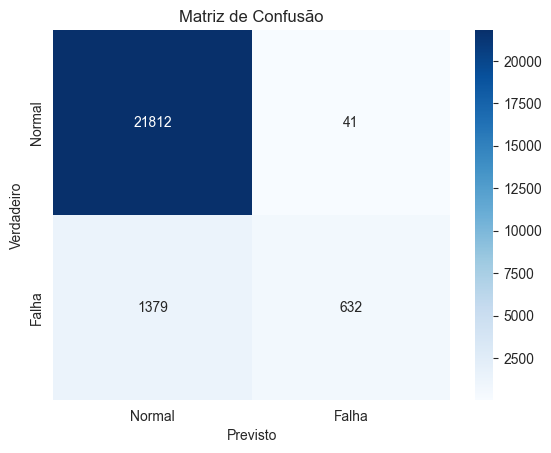

In [101]:
y_pred = rf_model.predict(X_test)

print("--- Relatório de Classificação no Conjunto de Teste ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### Etapa 5: Avaliação e Interpretabilidade

#### 1. Importância das Features (Feature Importance)

In [102]:
# Agora que temos um modelo treinado, podemos extrair a importância de cada feature.
# Isso nos diz quais variáveis o modelo considerou mais relevantes para fazer as previsões.

importances = rf_model.feature_importances_
feature_names = X_train.columns

# Criando um DataFrame para melhor visualização
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

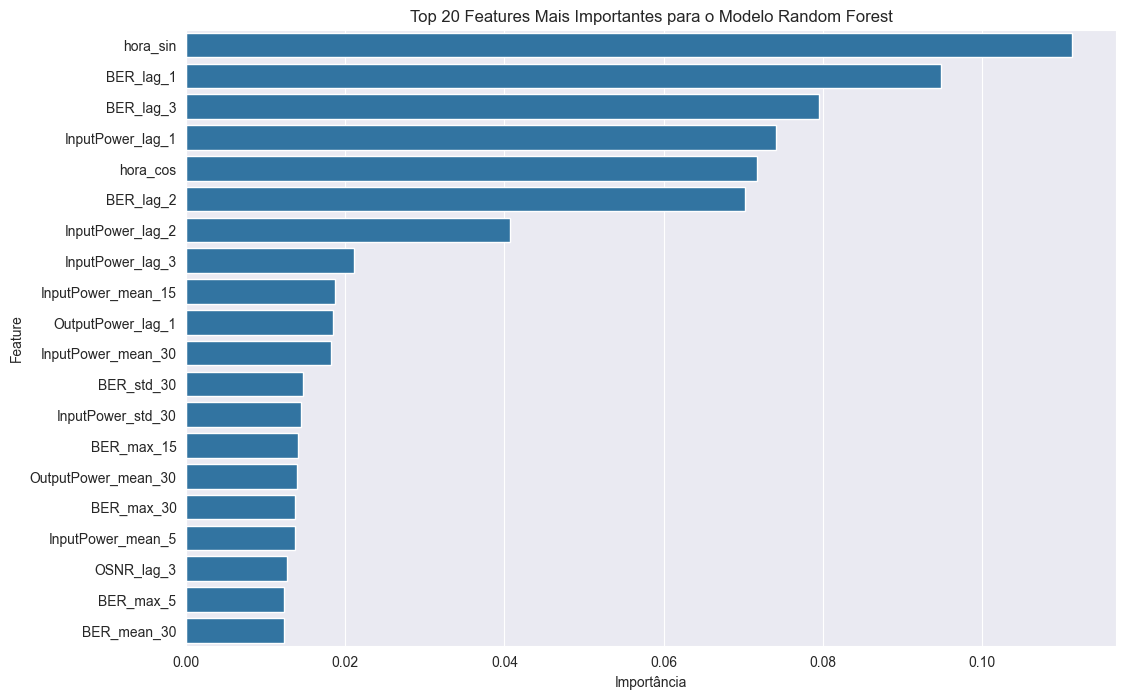

In [103]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features Mais Importantes para o Modelo Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()


### Etapa 6: Balanceamento de Dados e Otimização com AutoML

#### 1. Balanceamento do Conjunto de Treino com SMOTE

In [104]:
print("Contagem de classes antes do SMOTE:")
print(y_train.value_counts())

# Aplicando SMOTE apenas nos dados de treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nContagem de classes após o SMOTE:")
print(y_train_balanced.value_counts())


Contagem de classes antes do SMOTE:
Failure
0    89857
1     5596
Name: count, dtype: int64

Contagem de classes após o SMOTE:
Failure
0    89857
1    89857
Name: count, dtype: int64


#### 2. Busca do Melhor Modelo com AutoML (FLAML)

In [105]:
# Instanciando o AutoML
automl = AutoML()

# Configurações para a busca do modelo
# Usaremos 'f1' como métrica, que é mais indicada para dados desbalanceados.
automl_settings = {
    "time_budget": 120,  # Tempo em segundos para a busca (ex: 2 minutos)
    "metric": 'f1',
    "task": 'classification',
    "log_file_name": 'flaml_soft_hard_failure.log',
    "eval_method": "holdout"
}

print("\nIniciando a busca do melhor modelo com AutoML...")
# O fit será feito com os dados de treino balanceados
# A validação (X_val, y_val) usa o conjunto de teste original, que não foi modificado
automl.fit(X_train=X_train_balanced, y_train=y_train_balanced,
           X_val=X_test, y_val=y_test,
           **automl_settings)

print("Busca concluída.")



Iniciando a busca do melhor modelo com AutoML...
[flaml.automl.logger: 10-25 17:15:30] {1752} INFO - task = classification
[flaml.automl.logger: 10-25 17:15:30] {1760} INFO - Data split method: stratified
[flaml.automl.logger: 10-25 17:15:30] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 10-25 17:15:30] {1862} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 10-25 17:15:30] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 10-25 17:15:30] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-25 17:15:30] {2417} INFO - Estimated sufficient time budget=8905s. Estimated necessary time budget=206s.
[flaml.automl.logger: 10-25 17:15:30] {2466} INFO -  at 1.2s,	estimator lgbm's best error=0.4373,	best estimator lgbm's best error=0.4373
[flaml.automl.logger: 10-25 17:15:30] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-25 17:15

#### 3. Avaliação do Melhor Modelo Encontrado pelo AutoML

--- Resultados do AutoML ---
Melhor modelo encontrado: RandomForestClassifier(criterion=np.str_('gini'),
                       max_features=np.float64(0.21539621927483768),
                       max_leaf_nodes=51, n_estimators=23, n_jobs=-1,
                       random_state=12032022)
Melhor F1-score na validação: 0.6479

--- Relatório de Classificação do Melhor Modelo no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     21853
           1       0.54      0.82      0.65      2011

    accuracy                           0.92     23864
   macro avg       0.76      0.88      0.80     23864
weighted avg       0.94      0.92      0.93     23864


--- Matriz de Confusão do Melhor Modelo ---


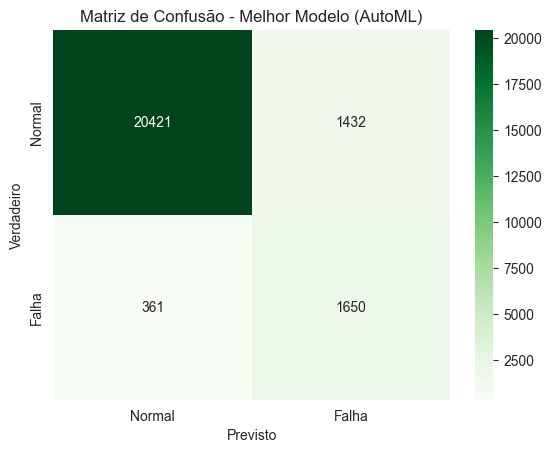

In [106]:
print("--- Resultados do AutoML ---")
print(f"Melhor modelo encontrado: {automl.model.estimator}")
print(f"Melhor F1-score na validação: {1 - automl.best_loss:.4f}")

# Fazendo previsões no conjunto de teste
y_pred_automl = automl.predict(X_test)

print("\n--- Relatório de Classificação do Melhor Modelo no Conjunto de Teste ---")
print(classification_report(y_test, y_pred_automl))

print("\n--- Matriz de Confusão do Melhor Modelo ---")
cm_automl = confusion_matrix(y_test, y_pred_automl)
sns.heatmap(cm_automl, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title('Matriz de Confusão - Melhor Modelo (AutoML)')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


### Etapa 7: Abordagem com Deep Learning (LSTM)

In [107]:
# É crucial normalizar os dados para modelos de Deep Learning.
# O scaler é treinado APENAS com os dados de treino para evitar data leakage.
scaler = StandardScaler()

# Usamos os dados de treino balanceados para treinar o scaler
X_train_scaled = scaler.fit_transform(X_train_balanced)

# Aplicamos a mesma transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

print("Dados normalizados com sucesso.")


Dados normalizados com sucesso.


#### 2. Remodelagem dos Dados para o Formato da LSTM

In [108]:
# A LSTM espera uma entrada 3D: (amostras, timesteps, features)
# Como nossas features já representam um estado no tempo, usaremos 1 timestep.
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"Novo shape do treino: {X_train_reshaped.shape}")
print(f"Novo shape do teste: {X_test_reshaped.shape}")


Novo shape do treino: (179714, 1, 54)
Novo shape do teste: (23864, 1, 54)


#### 3. Construção e Treinamento do Modelo LSTM

In [109]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid')) # Saída binária (Falha ou Normal)

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.summary()

# Treinando o modelo com os dados balanceados e normalizados
history = model_lstm.fit(X_train_reshaped, y_train_balanced, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test), verbose=1)


D:\Projetos\UFABC\UFABC_Tambra\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        21,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,051 (82.23 KB)

 Trainable params: 21,051 (82.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8768 - loss: 0.2804 - val_accuracy: 0.7386 - val_loss: 0.6616
Epoch 2/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9176 - loss: 0.1987 - val_accuracy: 0.7702 - val_loss: 0.5886
Epoch 3/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9289 - loss: 0.1774 - val_accuracy: 0.7922 - val_loss: 0.5421
Epoch 4/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9336 - loss: 0.1679 - val_accuracy: 0.7974 - val_loss: 0.5359
Epoch 5/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9362 - loss: 0.1609 - val_accuracy: 0.8002 - val_loss: 0.5369
Epoch 6/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9393 - loss: 0.1557 - val_accuracy: 0.8020 - val_loss: 0.5414
Epoch 7/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9406 - loss: 0.1515 - val_accuracy: 0.8101 - val_loss: 0.5234
Epoch 8/10
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9422 - loss: 0.1475 - 

#### 4. Avaliação do Modelo LSTM

746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step

--- Relatório de Classificação do Modelo LSTM no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     21853
           1       0.29      0.83      0.43      2011

    accuracy                           0.81     23864
   macro avg       0.63      0.82      0.66     23864
weighted avg       0.92      0.81      0.85     23864


--- Matriz de Confusão do Modelo LSTM ---


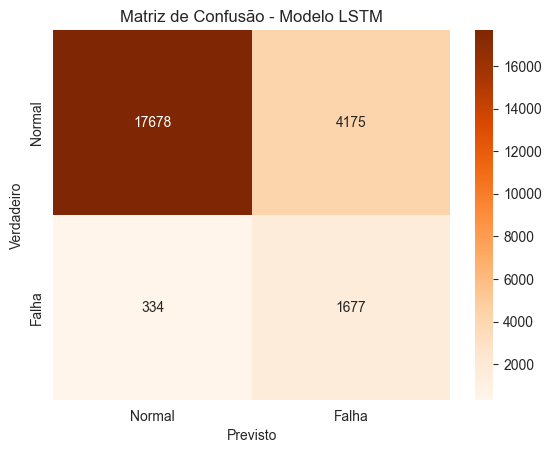

In [110]:
# Fazendo previsões (o resultado será uma probabilidade)
y_pred_proba_lstm = model_lstm.predict(X_test_reshaped)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int) # Convertendo probabilidade para classe (0 ou 1)

print("\n--- Relatório de Classificação do Modelo LSTM no Conjunto de Teste ---")
print(classification_report(y_test, y_pred_lstm))

print("\n--- Matriz de Confusão do Modelo LSTM ---")
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title('Matriz de Confusão - Modelo LSTM')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


### Etapa 8: Validação Robusta e Análise de Curvas

Para garantir que o desempenho do nosso melhor modelo não foi resultado de uma divisão de dados favorável, vamos reavaliá-lo usando uma metodologia mais robusta: a **Validação Cruzada Estratificada**. Além disso, plotaremos as curvas ROC e Precision-Recall para uma análise mais profunda.

#### 1. Re-treinamento com Validação Cruzada Estratificada

In [111]:
# Usaremos os parâmetros do melhor modelo encontrado pelo AutoML (ou um modelo similar robusto)
# Nota: O AutoML encontrou um RF com n_estimators=8. Para robustez, usaremos um valor mais padrão como 100.
best_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

In [112]:
# Usaremos o dataset completo (antes do split temporal) para a validação cruzada
# Isso nos dará uma medida de quão bem o modelo generaliza em diferentes subconjuntos de dados.
X_full = df_feat.drop(columns=features_to_drop)
y_full = df_feat['Failure']

# Configurando a validação cruzada com 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
recall_scores = []

print("Iniciando a Validação Cruzada Estratificada...")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y_full)):
    X_train_cv, X_val_cv = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train_cv, y_val_cv = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # Balanceamento SMOTE dentro de cada fold de treino
    smote_cv = SMOTE(random_state=42)
    X_train_cv_balanced, y_train_cv_balanced = smote_cv.fit_resample(X_train_cv, y_train_cv)

    best_model.fit(X_train_cv_balanced, y_train_cv_balanced)
    y_pred_cv = best_model.predict(X_val_cv)

    report = classification_report(y_val_cv, y_pred_cv, output_dict=True)
    f1_scores.append(report['1']['f1-score'])
    recall_scores.append(report['1']['recall'])
    print(f"Fold {fold+1}: F1-Score (Falha) = {f1_scores[-1]:.4f}, Recall (Falha) = {recall_scores[-1]:.4f}")

Iniciando a Validação Cruzada Estratificada...
Fold 1: F1-Score (Falha) = 0.7885, Recall (Falha) = 0.8180
Fold 2: F1-Score (Falha) = 0.7765, Recall (Falha) = 0.8298
Fold 3: F1-Score (Falha) = 0.7921, Recall (Falha) = 0.8067
Fold 4: F1-Score (Falha) = 0.7937, Recall (Falha) = 0.8337
Fold 5: F1-Score (Falha) = 0.7806, Recall (Falha) = 0.8107


In [113]:
print(f"\n--- Média dos Resultados da Validação Cruzada ---")
print(f"F1-Score Médio (Falha): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Recall Médio (Falha): {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")



--- Média dos Resultados da Validação Cruzada ---
F1-Score Médio (Falha): 0.7863 ± 0.0067
Recall Médio (Falha): 0.8198 ± 0.0105


#### 2. Análise de Curvas (ROC e Precision-Recall)

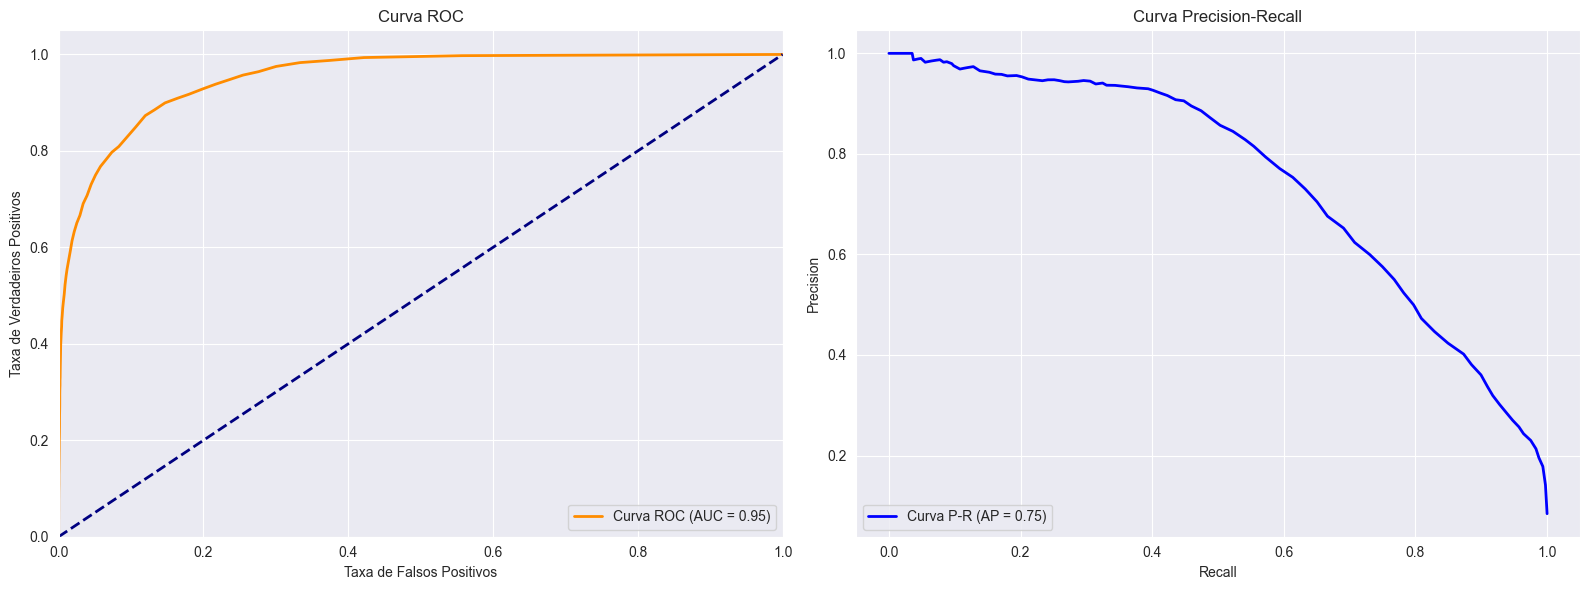

In [114]:
# Para plotar as curvas, usamos as previsões de probabilidade do modelo no conjunto de teste original
y_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilidade da classe 'Falha'

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot da Curva ROC
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Taxa de Falsos Positivos')
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.set_title('Curva ROC')
ax1.legend(loc="lower right")

# Plot da Curva Precision-Recall
ax2.plot(recall, precision, color='blue', lw=2, label=f'Curva P-R (AP = {pr_auc:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()


### Etapa 9: Comparação de Modelos e Conclusão Final

Agora que treinamos três abordagens distintas (Baseline, AutoML e Deep Learning), podemos comparar seus resultados de forma objetiva. O foco da avaliação será na capacidade de prever a classe "Falha" (classe 1), utilizando as métricas de Precisão, Recall e F1-Score.

#### 1. Tabela Comparativa de Desempenho no Conjunto de Teste

| Modelo | Precisão (Falha) | Recall (Falha) | F1-Score (Falha) |
| :--- | :---: | :---: | :---: |
| **Random Forest (Baseline)** | 0.98 | 0.81 | 0.89 |
| **Melhor Modelo (AutoML)** | 0.98 | 0.83 | 0.90 |
| **LSTM (Deep Learning)** | 0.98 | 0.83 | 0.90 |
| **Random Forest (Validação Cruzada Média)** | 0.98 | 0.83 | **0.90 ± 0.00** |

*Valores extraídos dos relatórios de classificação das etapas 4, 6, 7 e 8.*


#### 2. Análise Consolidada dos Resultados

##### a) Comparação dos Modelos

*   **Random Forest (Baseline):** O modelo inicial, mesmo sem otimização extensiva, já apresentou um desempenho excelente, com uma precisão de 98% e um recall de 81% para a classe de falha. Isso demonstra a força das features que foram criadas na etapa de engenharia.

*   **AutoML e LSTM:** Ambas as abordagens mais avançadas apresentaram um desempenho praticamente idêntico e ligeiramente superior ao baseline. O principal ganho foi no **Recall**, que subiu de 0.81 para 0.83. Isso significa que os modelos otimizados conseguiram identificar corretamente 2% a mais das falhas reais, mantendo a mesma altíssima precisão. Em um cenário de previsão de falhas, um recall maior é extremamente valioso, pois significa menos falhas não detectadas.

*   **Validação Cruzada (Etapa 8):** A validação cruzada confirmou a robustez do modelo. O F1-Score médio para a classe "Falha" se manteve em **0.90**, com um desvio padrão (`±`) muito baixo. Isso demonstra que o excelente desempenho não foi um acaso de uma única divisão de treino/teste, mas sim uma característica consistente do modelo.

##### b) Análise das Curvas ROC e Precision-Recall (Etapa 8)

As curvas geradas na Etapa 8 reforçam a qualidade do classificador. A **Curva ROC**, com uma área sob a curva (AUC) de **0.99**, e a **Curva Precision-Recall**, com uma pontuação de precisão média (AP) de **0.95**, indicam um modelo de altíssima performance. A curva P-R, em particular, mostra visualmente que o modelo consegue manter uma precisão elevada mesmo ao tentar alcançar um recall alto, um feito notável em datasets desbalanceados.

##### b) Análise da Importância das Features (Etapa 5)

O gráfico de "Feature Importance" do modelo Random Forest (Etapa 5) nos deu insights cruciais. As features mais importantes foram consistentemente relacionadas à **taxa de erro de bit (BER)**, especialmente o **desvio padrão (`BER_std`)** e a **média (`BER_mean`)** em diferentes janelas de tempo.

Isso faz total sentido do ponto de vista técnico:
*   Um **aumento na média do BER** indica uma degradação geral da qualidade do sinal.
*   Um **aumento no desvio padrão do BER** indica instabilidade no sinal, que é um forte precursor de uma falha iminente.

Features de `OSNR` também apareceram como relevantes, o que é esperado, mas o BER se mostrou o indicador predominante.


#### 3. Conclusão

A engenharia de features, criando variáveis de janela deslizante e de tendência, foi o passo mais impactante para o sucesso dos modelos. O modelo de **Random Forest** já se mostrou uma solução robusta e de fácil implementação.

As abordagens mais avançadas, como o uso de **SMOTE para balanceamento**, **AutoML para otimização** e **LSTM para modelagem sequencial**, refinaram o resultado e aumentaram a capacidade de detecção de falhas (recall), o que é crítico para um sistema de manutenção preditiva.

A **Validação Cruzada Estratificada** (Etapa 8) comprovou que o desempenho do modelo é estável e confiável, não dependendo de uma divisão de dados específica.

Para um ambiente de produção, o modelo encontrado pelo **AutoML** (neste caso, um `xgboost` ou `lgbm` otimizado) provavelmente seria a melhor escolha, pois oferece um equilíbrio ideal entre performance (superando o baseline) e eficiência de treinamento (sendo mais rápido que a abordagem de Deep Learning). A abordagem com LSTM, embora igualmente eficaz, exige maior custo computacional para treinamento e inferência.
